In [7]:
! pip freeze

absl-py==2.3.1
asttokens==3.0.0
astunparse==1.6.3
beautifulsoup4==4.14.3
bitsets==0.9.1
bs4==0.0.2
certifi==2025.11.12
charset-normalizer==3.4.4
colorama==0.4.6
comm==0.2.2
concepts==0.9.2
contourpy==1.3.2
cycler==0.12.1
debugpy==1.8.14
decorator==5.2.1
et_xmlfile==2.0.0
executing==2.2.0
features==0.5.12
fileconfig==0.7
flatbuffers==25.9.23
fonttools==4.57.0
gast==0.7.0
google-pasta==0.2.0
graphviz==0.21
grpcio==1.76.0
h5py==3.15.1
hdbscan==0.8.41
idna==3.11
ipykernel==6.29.5
ipython==9.2.0
ipython_pygments_lexers==1.1.1
jedi==0.19.2
joblib==1.5.0
jupyter_client==8.6.3
jupyter_core==5.7.2
kagglehub==0.3.13
keras==3.12.0
kiwisolver==1.4.8
libclang==18.1.1
loader==2017.9.11
Markdown==3.10
markdown-it-py==4.0.0
MarkupSafe==3.0.3
matplotlib==3.10.3
matplotlib-inline==0.1.7
mdurl==0.1.2
ml_dtypes==0.5.4
namex==0.1.0
narwhals==1.38.2
nest-asyncio==1.6.0
nltk==3.2.4
numpy==2.2.5
openpyxl==3.1.5
opt_einsum==3.4.0
optree==0.18.0
packaging==25.0
pandas==2.2.3
parso==0.8.4
patsy==1.0.1
pillow==11

In [3]:
# ============================
# IMPORTS E CONFIGURAÇÕES
# ============================

# Manipulação numérica e dados tabulares
import numpy as np
import pandas as pd

# Manipulação de caminhos de arquivos
from pathlib import Path

# Estatística e processamento de sinais
from scipy.stats import kurtosis
from scipy.signal import welch

# Pré-processamento e aprendizado não supervisionado
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Clustering baseado em densidade
import hdbscan

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo padrão dos gráficos
sns.set(style="whitegrid")


In [4]:
# ============================
# PARÂMETROS DO EXPERIMENTO
# ============================

# Frequência de amostragem do sinal de vibração (Hz)
# Deve ser definida conforme o dataset utilizado
FS = 256  

# Parâmetros de janelamento
WINDOW_SIZE = 1024          # Número de amostras por janela
OVERLAP = 0.5               # Sobreposição entre janelas (50%)
STEP = int(WINDOW_SIZE * (1 - OVERLAP))  # Passo entre janelas

# Eixos de aceleração presentes no dataset
AXES = ["AccX", "AccY", "AccZ"]

# Bandas de frequência para extração de energia espectral (Hz)
FREQ_BANDS = [
    (0, 10),
    (10, 50),
    (50, 100),
    (100, 200)
]

# Caminho para os dados brutos
DATA_PATH = Path("parquet")


In [5]:
# ============================
# LEITURA DOS DADOS BRUTOS
# ============================

# Lista de arquivos parquet contendo sinais de vibração
files = sorted(DATA_PATH.glob("*.parquet"))

# Leitura e concatenação dos arquivos
dfs = []
for f in files:
    df = pd.read_parquet(f)
    
    # Identificação da origem do sinal
    df["source_file"] = f.name
    dfs.append(df)

# DataFrame único com todos os sinais
raw_df = pd.concat(dfs, ignore_index=True)

raw_df.head()


,AccX_rms,AccX_var,AccX_kurtosis,AccX_ptp,AccX_band_energy_0_10,AccX_band_energy_10_50,AccX_band_energy_50_100,AccX_band_energy_100_200,AccY_rms,AccY_var,...,AccY_band_energy_50_150,AccY_band_energy_150_300,AccY_band_energy_300_600,AccY_band_energy_600_1200,AccZ_spectral_centroid,AccZ_band_energy_0_50,AccZ_band_energy_50_150,AccZ_band_energy_150_300,AccZ_band_energy_300_600,AccZ_band_energy_600_1200
0,1797.108013,3.134771e+06,-0.309460,10250.0,0.014312,0.342195,0.390267,0.253226,621.908491,351991.199142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1779.539711,3.068172e+06,-0.304178,9312.0,0.014648,0.353696,0.402169,0.229487,634.033646,368075.067856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1778.648648,3.068051e+06,-0.278869,9244.0,0.008914,0.371560,0.394420,0.225107,640.146926,373751.516059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1834.189272,3.272468e+06,-0.301499,10003.0,0.012480,0.356129,0.405330,0.226062,640.768460,372181.998764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1830.595457,3.262835e+06,-0.276392,10912.0,0.010095,0.352839,0.385047,0.252019,640.100497,374913.605556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# ============================
# GERAÇÃO DE JANELAS TEMPORAIS
# ============================

def generate_windows(df, window_size, step):
    """
    Divide cada arquivo de sinal em janelas deslizantes.
    Cada janela representa um segmento temporal do sinal.
    """
    windows = []

    # Processamento independente por arquivo
    for fname, df_file in df.groupby("source_file"):
        n = len(df_file)

        # Ignora arquivos menores que o tamanho da janela
        if n < window_size:
            continue

        # Geração das janelas
        for start in range(0, n - window_size + 1, step):
            win = df_file.iloc[start:start + window_size].copy()
            
            # Identificadores da janela
            win["window_id"] = start // step
            win["window_start"] = start
            win["source_file"] = fname
            
            windows.append(win)

    return windows


# Criação efetiva das janelas
windows = generate_windows(raw_df, WINDOW_SIZE, STEP)

len(windows)


6921

In [28]:
# ============================
# EXTRAÇÃO DE FEATURES
# ============================

def extract_features(window):
    """
    Extrai features estatísticas no tempo e no domínio da frequência
    para cada eixo de aceleração.
    """
    feats = {}

    for ax in AXES:
        x = window[ax].values

        # Features no domínio do tempo
        feats[f"{ax}_rms"] = np.sqrt(np.mean(x**2))
        feats[f"{ax}_var"] = np.var(x)
        feats[f"{ax}_kurtosis"] = kurtosis(x)
        feats[f"{ax}_ptp"] = np.ptp(x)

        # Estimativa espectral via Welch
        freqs, psd = welch(x, fs=FS, nperseg=len(x))
        total_power = np.sum(psd)

        # Energia espectral normalizada por banda
        for fmin, fmax in FREQ_BANDS:
            mask = (freqs >= fmin) & (freqs < fmax)
            feats[f"{ax}_band_energy_{fmin}_{fmax}"] = (
                np.sum(psd[mask]) / total_power if total_power > 0 else 0
            )

    return feats


In [29]:
# ============================
# CONSTRUÇÃO DO DATASET DE FEATURES
# ============================

feature_rows = []

# Extração de features para cada janela
for w in windows:
    feats = extract_features(w)
    
    # Metadados da janela
    feats["source_file"] = w["source_file"].iloc[0]
    feats["window_id"] = w["window_id"].iloc[0]
    feats["window_start"] = w["window_start"].iloc[0]
    
    feature_rows.append(feats)

# DataFrame final de features
features_df = pd.DataFrame(feature_rows)

features_df.head()


,AccX_rms,AccX_var,AccX_kurtosis,AccX_ptp,AccX_band_energy_0_10,AccX_band_energy_10_50,AccX_band_energy_50_100,AccX_band_energy_100_200,AccY_rms,AccY_var,...,AccZ_var,AccZ_kurtosis,AccZ_ptp,AccZ_band_energy_0_10,AccZ_band_energy_10_50,AccZ_band_energy_50_100,AccZ_band_energy_100_200,source_file,window_id,window_start
0,1797.108013,3.134771e+06,-0.309460,10250.0,0.014312,0.342195,0.390267,0.253226,621.908491,351991.199142,...,6.381155e+06,-0.254586,15311.0,0.037965,0.316215,0.312675,0.333145,vibration_all.parquet,0,0
1,1779.539711,3.068172e+06,-0.304178,9312.0,0.014648,0.353696,0.402169,0.229487,634.033646,368075.067856,...,5.782885e+06,-0.232626,15217.0,0.021441,0.394617,0.284191,0.299752,vibration_all.parquet,1,512
2,1778.648648,3.068051e+06,-0.278869,9244.0,0.008914,0.371560,0.394420,0.225107,640.146926,373751.516059,...,5.937336e+06,-0.054928,15609.0,0.046806,0.376650,0.316780,0.259764,vibration_all.parquet,2,1024
3,1834.189272,3.272468e+06,-0.301499,10003.0,0.012480,0.356129,0.405330,0.226062,640.768460,372181.998764,...,6.158648e+06,-0.161776,15679.0,0.026255,0.371016,0.338191,0.264538,vibration_all.parquet,3,1536
4,1830.595457,3.262835e+06,-0.276392,10912.0,0.010095,0.352839,0.385047,0.252019,640.100497,374913.605556,...,6.275305e+06,-0.165548,15159.0,0.032428,0.282358,0.331337,0.353877,vibration_all.parquet,4,2048


In [30]:
# ============================
# SELEÇÃO DAS FEATURES
# ============================

# Seleção apenas das colunas numéricas (features)
feature_cols = [
    c for c in features_df.columns
    if c not in ["source_file", "window_id", "window_start"]
]

# Matriz de entrada para os algoritmos
X = features_df[feature_cols].values


In [31]:
# ============================
# CLUSTERIZAÇÃO COM KMEANS
# ============================

# Pipeline com imputação, normalização e KMeans
pipe_kmeans = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=4, random_state=42))
])

# Atribuição dos rótulos de cluster
features_df["cluster_kmeans"] = pipe_kmeans.fit_predict(X)


In [32]:
# ============================
# CLUSTERIZAÇÃO COM HDBSCAN
# ============================

# Pré-processamento (HDBSCAN não faz parte de pipeline sklearn)
pipe_hdbscan = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Dados pré-processados
X_proc = pipe_hdbscan.fit_transform(X)

# Ajuste do modelo HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=30)
features_df["cluster_hdbscan"] = hdb.fit_predict(X_proc)


In [33]:
# ============================
# AVALIAÇÃO DOS CLUSTERS
# ============================

# ---- KMeans ----
# Uso do mesmo pré-processamento do pipeline
X_kmeans = pipe_kmeans[:-1].transform(X)
labels_km = features_df["cluster_kmeans"].values

sil_km = silhouette_score(X_kmeans, labels_km)
print("Silhouette KMeans:", sil_km)


# ---- HDBSCAN ----
labels_hdb = features_df["cluster_hdbscan"].values
mask = labels_hdb != -1  # Remove ruído

if mask.sum() > 1:
    sil_hdb = silhouette_score(X_proc[mask], labels_hdb[mask])
    print("Silhouette HDBSCAN:", sil_hdb)

print("Ruído (%):", np.mean(labels_hdb == -1) * 100)


Silhouette KMeans: 0.40668284607164723
Silhouette HDBSCAN: 0.6680429099121976
Ruído (%): 0.332899117093646


In [34]:
# ============================
# REDUÇÃO DE DIMENSIONALIDADE
# ============================

# PCA para projeção em 2D (visualização)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_proc)

features_df["pca1"] = X_pca[:, 0]
features_df["pca2"] = X_pca[:, 1]


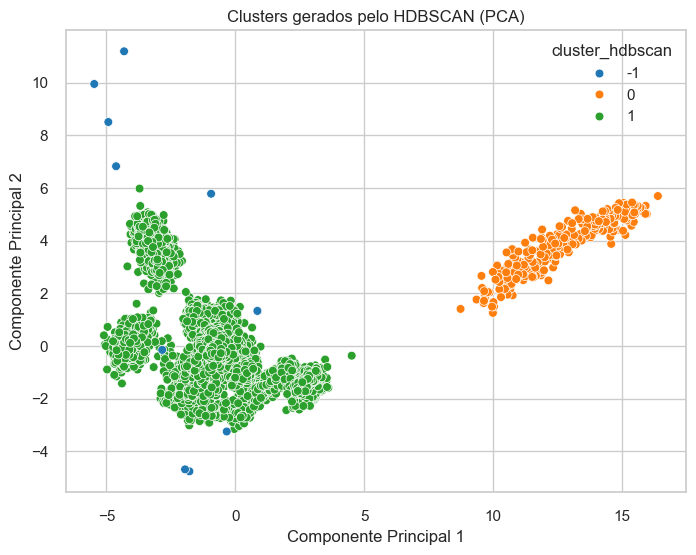

In [35]:
# ============================
# VISUALIZAÇÃO DOS CLUSTERS
# ============================

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=features_df,
    x="pca1",
    y="pca2",
    hue="cluster_hdbscan",
    palette="tab10",
    s=40
)

plt.title("Clusters gerados pelo HDBSCAN (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()


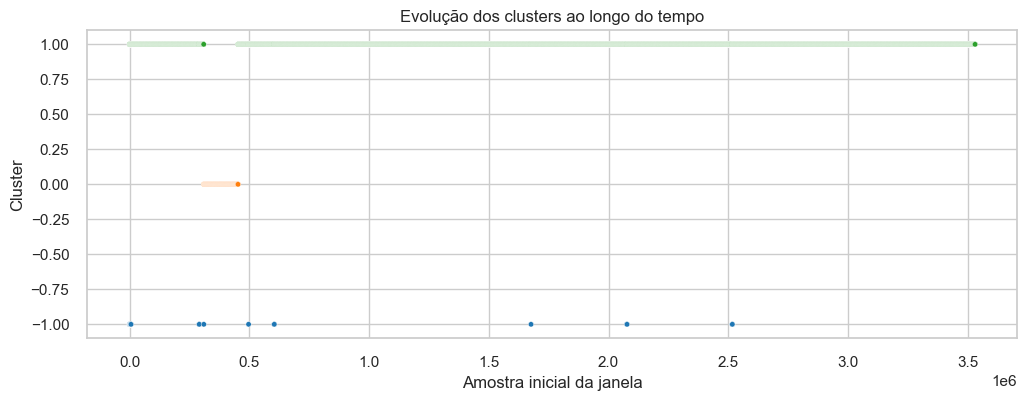

In [36]:
# ============================
# CLUSTERS AO LONGO DO TEMPO
# ============================

plt.figure(figsize=(12, 4))

sns.scatterplot(
    data=features_df,
    x="window_start",
    y="cluster_hdbscan",
    hue="cluster_hdbscan",
    palette="tab10",
    legend=False,
    s=15
)

plt.title("Evolução dos clusters ao longo do tempo")
plt.xlabel("Amostra inicial da janela")
plt.ylabel("Cluster")
plt.show()


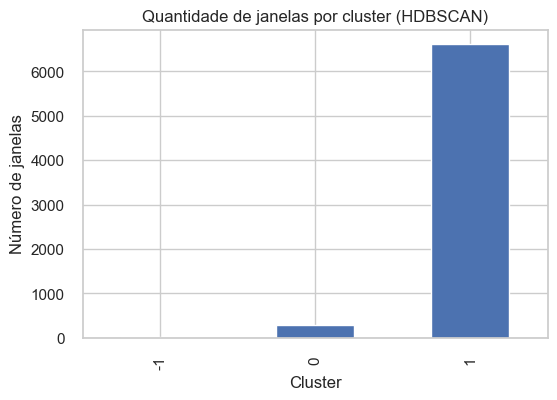

In [37]:
# ============================
# TAMANHO DOS CLUSTERS
# ============================

cluster_counts = (
    features_df["cluster_hdbscan"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(6, 4))
cluster_counts.plot(kind="bar")

plt.title("Quantidade de janelas por cluster (HDBSCAN)")
plt.xlabel("Cluster")
plt.ylabel("Número de janelas")
plt.show()


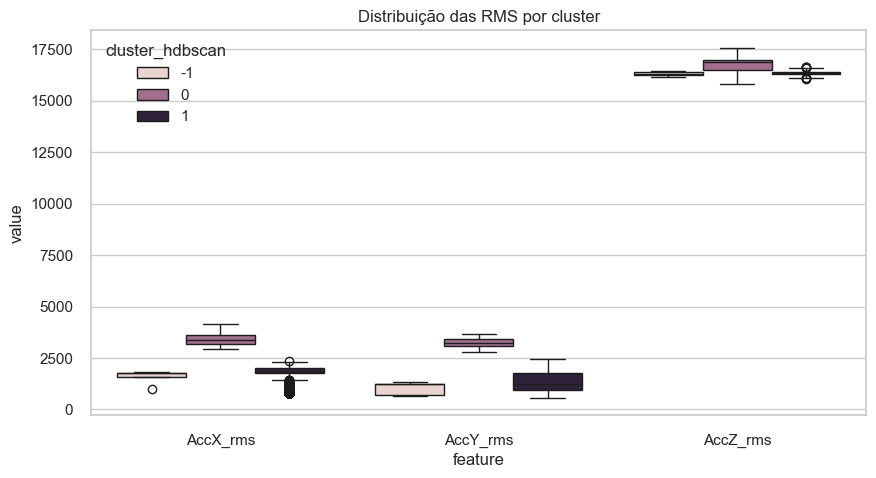

In [38]:
# ============================
# DISTRIBUIÇÃO DE FEATURES POR CLUSTER
# ============================

selected_features = [
    "AccX_rms",
    "AccY_rms",
    "AccZ_rms"
]

df_melt = features_df.melt(
    id_vars="cluster_hdbscan",
    value_vars=selected_features,
    var_name="feature",
    value_name="value"
)

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_melt,
    x="feature",
    y="value",
    hue="cluster_hdbscan"
)

plt.title("Distribuição das RMS por cluster")
plt.show()


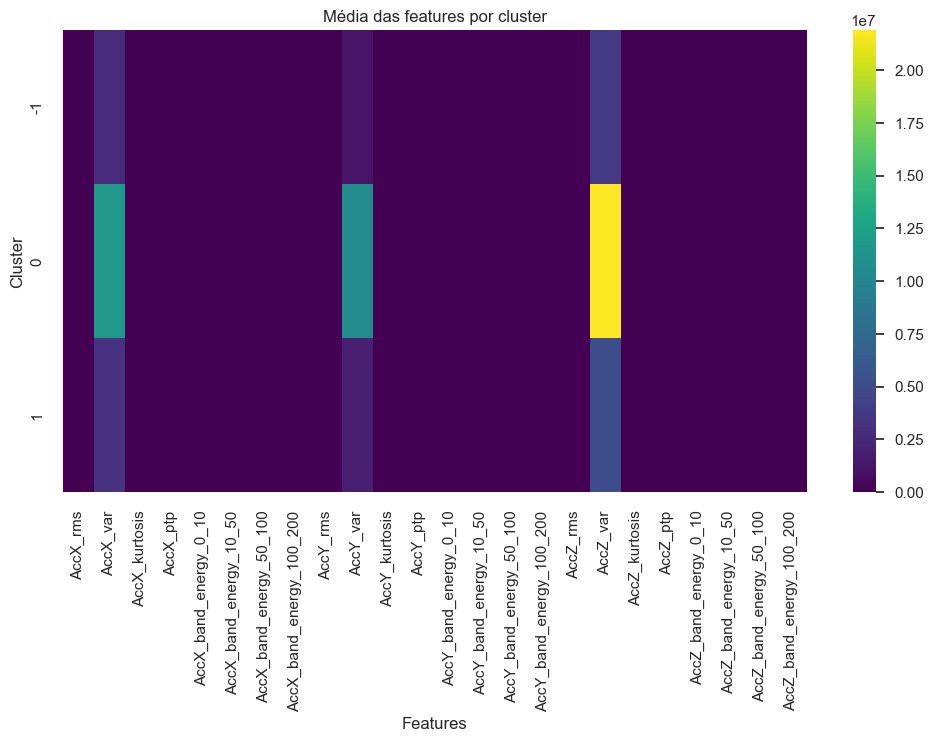

In [39]:
# ============================
# HEATMAP DAS FEATURES MÉDIAS
# ============================

cluster_means = (
    features_df
    .groupby("cluster_hdbscan")[feature_cols]
    .mean()
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_means,
    cmap="viridis",
    annot=False
)

plt.title("Média das features por cluster")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.show()


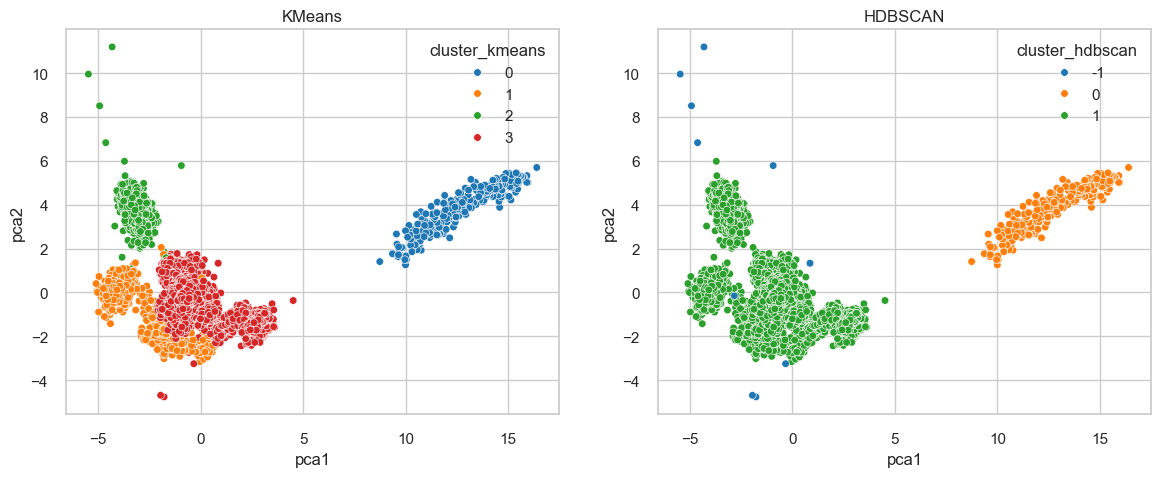

In [40]:
# ============================
# COMPARAÇÃO ENTRE MÉTODOS
# ============================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(
    data=features_df,
    x="pca1",
    y="pca2",
    hue="cluster_kmeans",
    palette="tab10",
    s=30,
    ax=axes[0]
)
axes[0].set_title("KMeans")

sns.scatterplot(
    data=features_df,
    x="pca1",
    y="pca2",
    hue="cluster_hdbscan",
    palette="tab10",
    s=30,
    ax=axes[1]
)
axes[1].set_title("HDBSCAN")

plt.show()


<Figure size 1200x500 with 0 Axes>

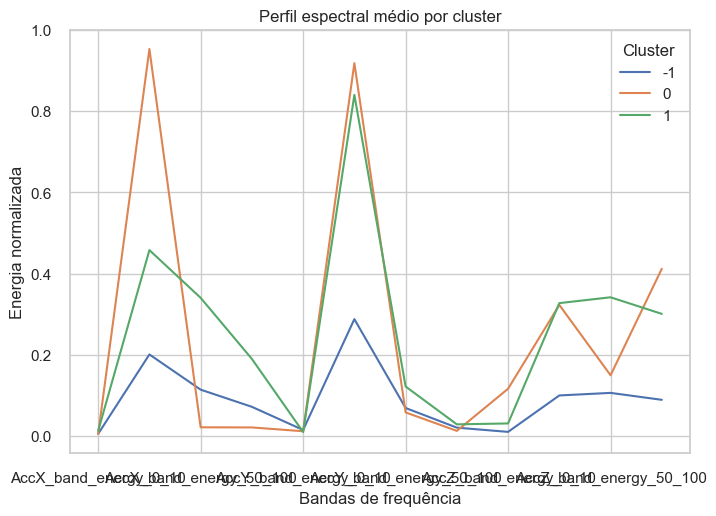

In [41]:
# ============================
# PERFIL ESPECTRAL MÉDIO
# ============================

band_cols = [c for c in feature_cols if "band_energy" in c]

cluster_band_means = (
    features_df
    .groupby("cluster_hdbscan")[band_cols]
    .mean()
)

plt.figure(figsize=(12, 5))
cluster_band_means.T.plot()

plt.title("Perfil espectral médio por cluster")
plt.xlabel("Bandas de frequência")
plt.ylabel("Energia normalizada")
plt.legend(title="Cluster")
plt.show()


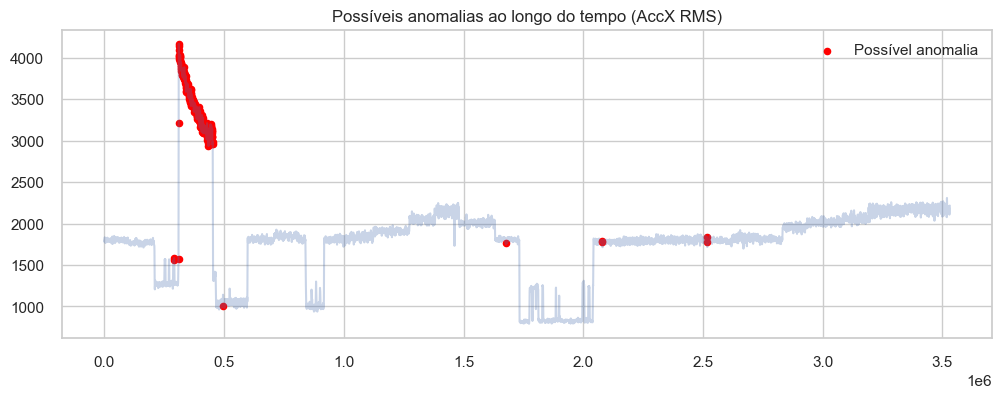

In [42]:
# ============================
# POSSÍVEIS ANOMALIAS
# ============================

# Considera clusters pequenos como possíveis anomalias
cluster_sizes = features_df["cluster_hdbscan"].value_counts()
small_clusters = cluster_sizes[cluster_sizes < 0.05 * len(features_df)].index

anomalies = features_df[
    features_df["cluster_hdbscan"].isin(small_clusters)
]

plt.figure(figsize=(12, 4))
plt.plot(features_df["window_start"], features_df["AccX_rms"], alpha=0.3)
plt.scatter(
    anomalies["window_start"],
    anomalies["AccX_rms"],
    color="red",
    s=20,
    label="Possível anomalia"
)

plt.legend()
plt.title("Possíveis anomalias ao longo do tempo (AccX RMS)")
plt.show()


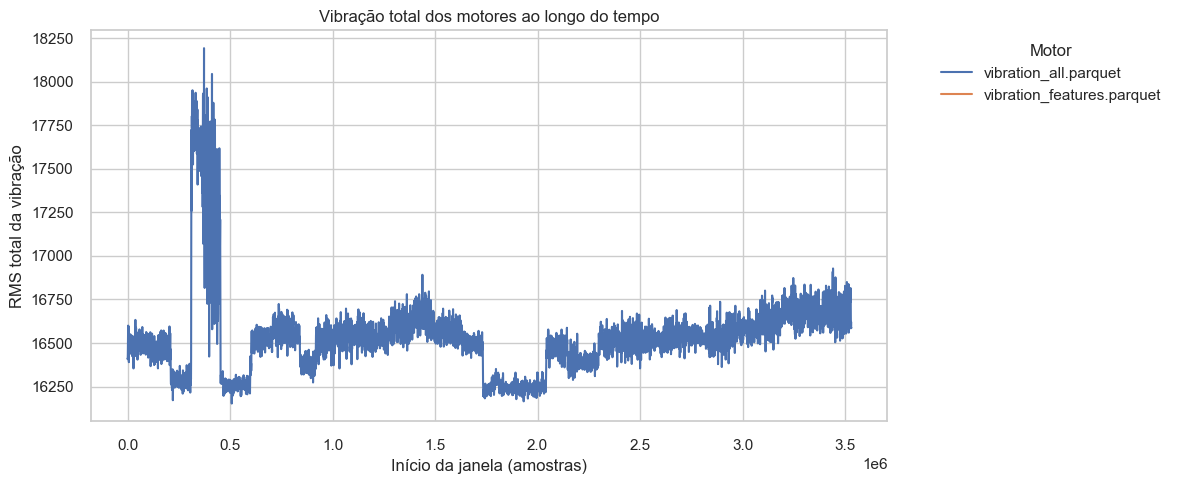

In [45]:
# ============================
# VIBRAÇÃO POR MOTOR - MODELO DE LINHAS
# ============================

# RMS total combinando os três eixos
features_df["RMS_total"] = np.sqrt(
    features_df["AccX_rms"]**2 +
    features_df["AccY_rms"]**2 +
    features_df["AccZ_rms"]**2
)

plt.figure(figsize=(12, 5))

sns.lineplot(
    data=features_df,
    x="window_start",
    y="RMS_total",
    hue="source_file",
    linewidth=1.5
)

plt.title("Vibração total dos motores ao longo do tempo")
plt.xlabel("Início da janela (amostras)")
plt.ylabel("RMS total da vibração")
plt.legend(title="Motor", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


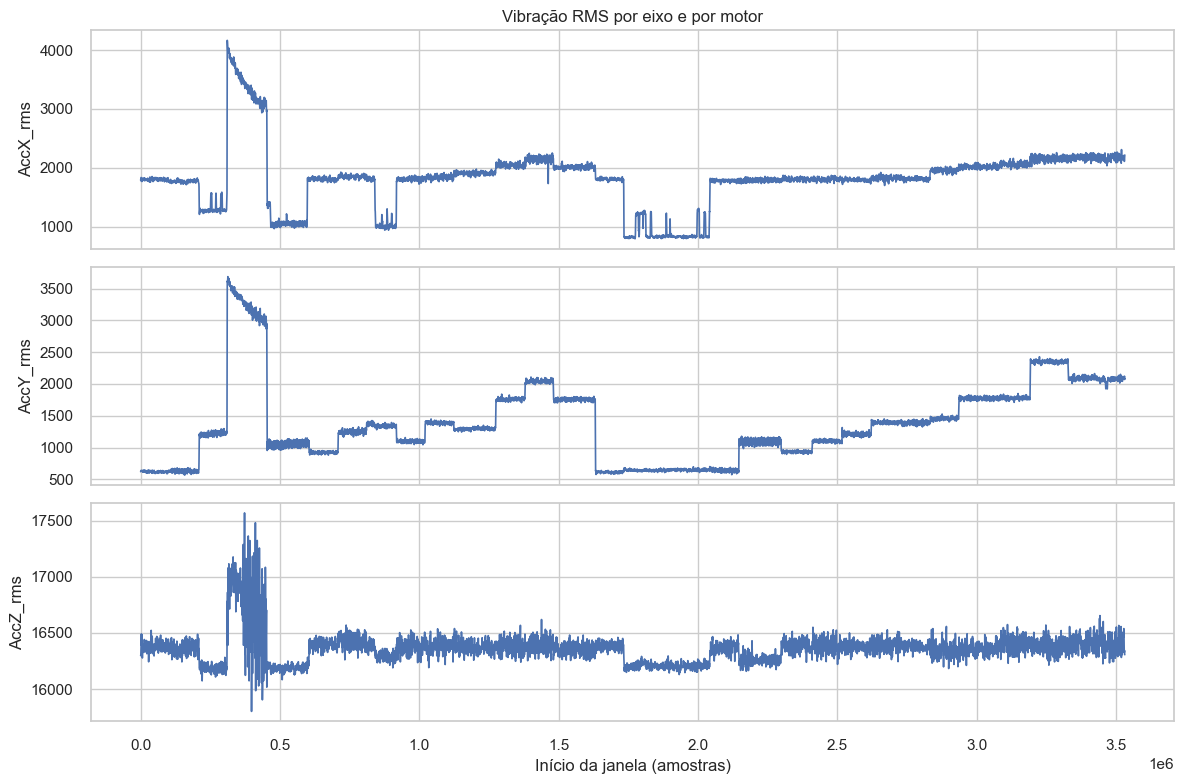

In [46]:
# ============================
# VIBRAÇÃO POR EIXO E MOTOR
# ============================

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes_list = zip(axes, ["AccX_rms", "AccY_rms", "AccZ_rms"])

for ax, feature in axes_list:
    sns.lineplot(
        data=features_df,
        x="window_start",
        y=feature,
        hue="source_file",
        linewidth=1.2,
        ax=ax
    )
    ax.set_ylabel(feature)
    ax.legend_.remove()

axes[0].set_title("Vibração RMS por eixo e por motor")
axes[-1].set_xlabel("Início da janela (amostras)")

plt.tight_layout()
plt.show()


In [47]:
# ============================
# LIMIARES DE ALERTA
# ============================

# RMS total
features_df["RMS_total"] = np.sqrt(
    features_df["AccX_rms"]**2 +
    features_df["AccY_rms"]**2 +
    features_df["AccZ_rms"]**2
)

# Estatística robusta
median_rms = features_df["RMS_total"].median()
std_rms = features_df["RMS_total"].std()

# Definição dos limiares
WARNING_THRESHOLD = median_rms + 2 * std_rms
ALERT_THRESHOLD = median_rms + 3 * std_rms

WARNING_THRESHOLD, ALERT_THRESHOLD


(np.float64(16997.007661612824), np.float64(17232.172636050356))

In [48]:
# ============================
# CLASSIFICAÇÃO DE ESTADO
# ============================

def classify_state(rms):
    if rms >= ALERT_THRESHOLD:
        return "Alerta"
    elif rms >= WARNING_THRESHOLD:
        return "Atenção"
    else:
        return "Normal"

features_df["estado"] = features_df["RMS_total"].apply(classify_state)

features_df["estado"].value_counts()


estado
Normal     6678
Alerta      190
Atenção      41
Name: count, dtype: int64

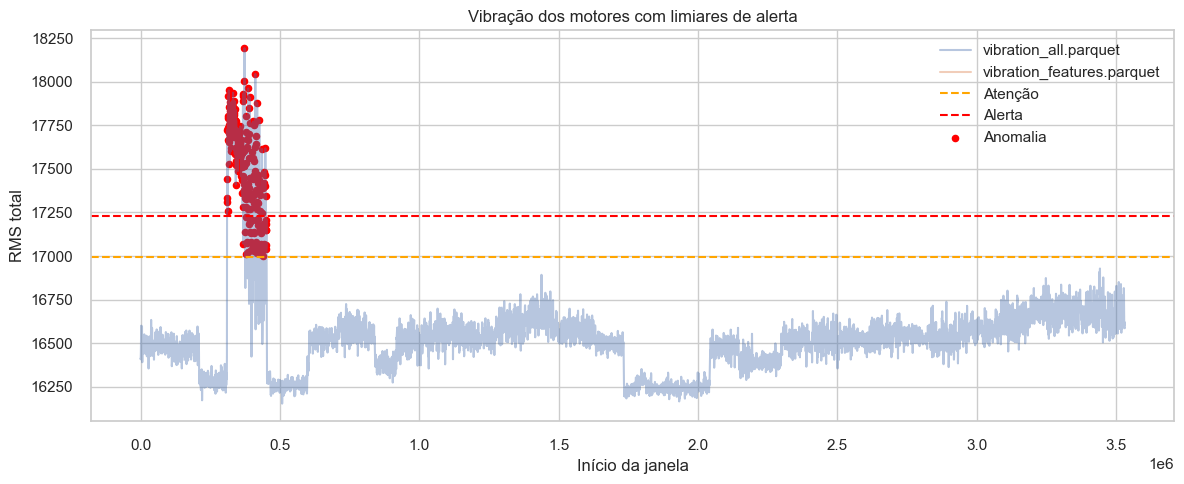

In [49]:
# ============================
# LINHAS COM DESTAQUE DE ANOMALIAS
# ============================

plt.figure(figsize=(12, 5))

sns.lineplot(
    data=features_df,
    x="window_start",
    y="RMS_total",
    hue="source_file",
    alpha=0.4
)

# Destaque visual
plt.axhline(WARNING_THRESHOLD, color="orange", linestyle="--", label="Atenção")
plt.axhline(ALERT_THRESHOLD, color="red", linestyle="--", label="Alerta")

# Pontos anômalos
anomalies = features_df[features_df["estado"] != "Normal"]

plt.scatter(
    anomalies["window_start"],
    anomalies["RMS_total"],
    color="red",
    s=20,
    label="Anomalia"
)

plt.title("Vibração dos motores com limiares de alerta")
plt.xlabel("Início da janela")
plt.ylabel("RMS total")
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
# ============================
# ESTADO VS CLUSTER
# ============================

cluster_state = (
    features_df
    .groupby("cluster_hdbscan")["estado"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

cluster_state


estado,Alerta,Atenção,Normal
cluster_hdbscan,,,
-1,0.000000,0.000000,1.000000
0,0.681004,0.146953,0.172043
1,0.000000,0.000000,1.000000


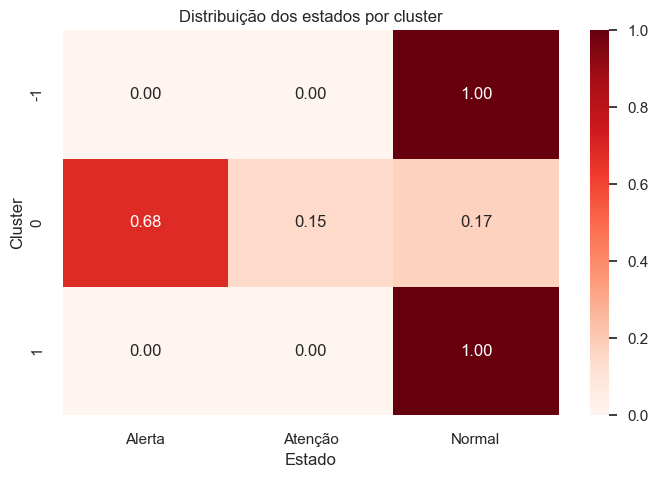

In [51]:
# ============================
# HEATMAP CLUSTER × ESTADO
# ============================

plt.figure(figsize=(8, 5))
sns.heatmap(
    cluster_state,
    annot=True,
    fmt=".2f",
    cmap="Reds"
)

plt.title("Distribuição dos estados por cluster")
plt.xlabel("Estado")
plt.ylabel("Cluster")
plt.show()


In [ ]:
features_df.to_parquet(
    r"C:\Users\leona\Desktop\01 - Projeto Python\Analise_de_Vibracoes\parquet\features.parquet")